In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn

# Hello world -- Learn a line!

As a first test I want to do the simplest possible equation I can think of, a line.

Lines show up in physics as the steady state solution of heat equations in 1D.  Normally the heat equation is $dy/dt=d^2y/dx^2$ but since we want the steady state equation let $dy=dt=0$. But we also want to anchor the line so it doesn't go where ever so I'll give it some boundary conditions of $y(0)=0$ and $y(1)=1$.

Physically this would correspond to something like a metal bar that is heated to a temperature of 0 on one end and 1 on the other end and let to sit for a long time.

In [2]:
class Unsqueeze(nn.Module):
    """Unsqueeze a tensor along a given dimension."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return x.unsqueeze(self.dim)

class Squeeze(nn.Module):
    """Squeeze a tensor along a given dimension."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return x.squeeze(self.dim)


In [ ]:
def create_1d_network(num_layers: int=4, num_channels: int=32, activation=nn.SiLU, device="cuda") -> torch.nn.Module:
    """Create a 1d network"""
    layers = []

    # Add channel dimenion
    layers.append(Unsqueeze(dim=1))

    layers.append(nn.Linear(1, num_channels))
    layers.append(activation())

    for _ in range(num_layers - 1):
        layers.append(nn.Linear(num_channels, num_channels))
        layers.append(activation())

    # Final layer to reduce to single output channel
    layers.append(nn.Linear(num_channels, 1))

    # Remove channel dimension
    layers.append(Squeeze(dim=1))
    
    network = nn.Sequential(*layers)
    return network.to(device)


# Example usage
def example_usage():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    network = create_1d_network(device=device)

    points = torch.linspace(0, 1, steps=10, device=device).unsqueeze(-1)  # Shape (100, 1
    print(network(points))  # Forward pass to check everything works

example_usage()

tensor([[0.2041],
        [0.2039],
        [0.2036],
        [0.2033],
        [0.2029],
        [0.2025],
        [0.2020],
        [0.2015],
        [0.2010],
        [0.2004]], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [100]:
# Training loop for a simple 1D PINN solving a boundary value problem
network = create_1d_network(device=device)
num_points_per_batch = 1000
num_epochs = 1000
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
mse_loss = nn.MSELoss()

# Boundary conditions at x=0 and x=1
x_bc = torch.tensor([0.0, 1.0], device=device)
y_bc = torch.tensor([0.0, 1.0], device=device)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Input values
    interior_times = torch.rand(num_points_per_batch - 2, device=device, requires_grad=True)
    sampled_times = torch.cat([x_bc, interior_times], dim=0)

    # Forward pass
    displacement_pred = network(sampled_times)

    # Compute the residual of the differential equation
    dx_dt = torch.autograd.grad(displacement_pred, sampled_times, grad_outputs=torch.ones_like(displacement_pred), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, sampled_times, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
    residual = d2x_dt2
    residual_loss = mse_loss(residual, torch.zeros_like(residual))  # PDE residual loss, e.g., for d2T/dx2 = 0

    # Compute the boundary conditions
    bc_loss = mse_loss(displacement_pred[:2] , y_bc)  # Boundary condition loss

    # Total loss
    loss = residual_loss + bc_loss

    # Backward pass and optimization step
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.499837726354599
Epoch 100, Loss: 0.0001845080405473709
Epoch 200, Loss: 7.295486739167245e-07
Epoch 300, Loss: 3.809276734045852e-07
Epoch 400, Loss: 2.3401132409617276e-07
Epoch 500, Loss: 2.1072776235087076e-07
Epoch 600, Loss: 1.8586177930046688e-07
Epoch 700, Loss: 1.7997579959683208e-07
Epoch 800, Loss: 1.6499747346188087e-07
Epoch 900, Loss: 1.7470078716996795e-07


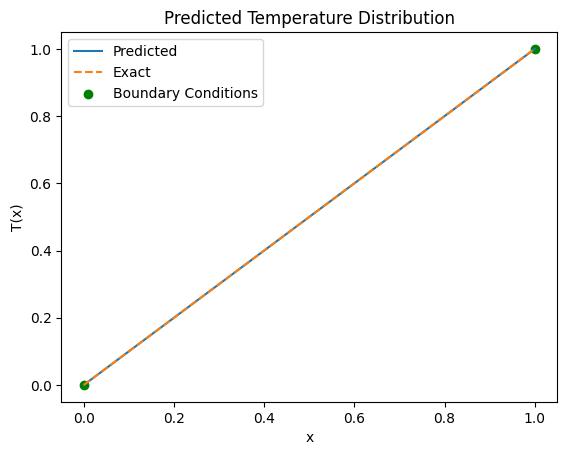

In [101]:
grid =  torch.linspace(0, 1, steps=100, device=device)

displacement_pred = network(grid)
plt.plot(grid.detach().cpu().numpy(), displacement_pred.detach().cpu().numpy(), label="Predicted")
plt.plot(grid.detach().cpu().numpy(), grid.detach().cpu().numpy(), label="Exact", linestyle='dashed')
plt.scatter([0, 1], [0, 1], color='green', label="Boundary Conditions")

plt.legend()
plt.xlabel("x")
plt.ylabel("T(x)")
plt.title("Predicted Temperature Distribution")
plt.show()

## Analysis

Looks like a neural network is about as good as linear regression for two points!

I used a smooth activation, SiLU (my favorite activation) instead of ReLU so that the derivatives would be as smooth as possible.

What I learned:

- I tried originally using a convolutional neural network with a grid. I found that the network didn't try to keep the derivative zero between the points on the grid, just on the grid points. That's why I switched to random sampling, nowhere for those pesky derivatives to hide!

- I originally thought about using numerical differentiation using neighboring points, then I realized how silly that is since neural networks can do derivatives. They are basically designed for them!

- I went back and tried with ReLU and the losses got lower but the plot was no longer a straight line. It still hit the boundary conditions and since the losses were super low I'm sure the second derivatives were getting low at virtually every point. But the point where the ReLU's second derivative aren't defined is enough to ruin everything, as I suspected.

# Upping the stakes -- damped harmonic oscillation

A damped harmonic oscillator satifies the equation:

$md^2x/dt^2+cdx/dt+kx=0$

where $m$ is the mass, $c$ is the damping coefficient, $k$ is the spring constant$, $x(t)$ is the displacement. The solutions are well known: https://en.wikipedia.org/wiki/Harmonic_oscillator.

I'll use the "dimensionless" form though:

$dx^2/dt^2+2\zeta\omega_0dx/dt+\omega_0^2=0$.

Here, $\omega_0$ is the "undamped angular frequency"--the frequency it would naturally osillate at without damping--and $zeta$ is the damping ratio. I'll have $\omega_0=2\pi$ and let $\zeta=0.8$ so that the system gets some oscillation and dies out.  I also need to define initial conditions, so I'll let $x(0)=0$ and $x'(0)=1$, which means I release the oscillator with a bit of a push from equilibrium position.

This problem is quite a bit different than the last from a mathematicaly perspective. Now the independent variable is time, not space, it is an initial value problem, not a boundary value problem, and the solution is more interesting than a line. Let's see how the old neurons do on this one!

In [27]:
# Training loop for a simple 1D PINN solving an initial value problem
network = create_1d_network(num_channels=128, device=device)
num_points_per_batch = 1000
num_epochs = 5000
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
mse_loss = nn.MSELoss()

# Initial displacement at x=1
x_bc = torch.tensor([0.0], device=device)
y_bc = torch.tensor([0.0], device=device)  # Initial displacement at t=0
y_ic = torch.tensor([1.0], device=device)  # Initial velocity at t=0

# Physical parameters
zeta = 0.3  # Damping ratio
omega = 2 * np.pi  # Natural frequency
duration = 5.0  # Duration of the simulation

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Input values
    interior_times = duration * torch.rand(num_points_per_batch - 2, device=device, requires_grad=True)
    sampled_times = torch.cat([x_bc, interior_times], dim=0)

    # Forward pass
    displacement_pred = network(sampled_times)

    # Compute the residual of the differential equation
    dx_dt = torch.autograd.grad(displacement_pred, sampled_times, grad_outputs=torch.ones_like(displacement_pred), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, sampled_times, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
    residual = d2x_dt2 + 2*zeta*omega*dx_dt + omega**2*displacement_pred
    residual_loss = mse_loss(residual, torch.zeros_like(residual))  # PDE residual loss, e.g., for d2x_dt2 = 0

    # Compute the boundary conditions
    bc_loss = mse_loss(displacement_pred[:1] , y_bc)  # Boundary condition loss
    ic_loss = mse_loss(dx_dt[:1] , y_ic)  # Initial condition loss

    # Total loss
    loss = residual_loss + 100 * num_points_per_batch*(bc_loss + ic_loss)

    # Backward pass and optimization step
    loss.backward()
    
    nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 100282.5859375
Epoch 100, Loss: 469.4267272949219
Epoch 200, Loss: 152.4786376953125
Epoch 300, Loss: 188.7504425048828
Epoch 400, Loss: 14.879517555236816
Epoch 500, Loss: 17.322742462158203
Epoch 600, Loss: 184.696533203125
Epoch 700, Loss: 8.959524154663086
Epoch 800, Loss: 18.308284759521484
Epoch 900, Loss: 134.4349822998047
Epoch 1000, Loss: 8.353303909301758
Epoch 1100, Loss: 12.72905158996582
Epoch 1200, Loss: 115.80925750732422
Epoch 1300, Loss: 6.089050769805908
Epoch 1400, Loss: 10.935948371887207
Epoch 1500, Loss: 91.31425476074219
Epoch 1600, Loss: 5.351665496826172
Epoch 1700, Loss: 8.724384307861328
Epoch 1800, Loss: 69.85791015625
Epoch 1900, Loss: 4.370005130767822
Epoch 2000, Loss: 7.25905704498291
Epoch 2100, Loss: 50.4991340637207
Epoch 2200, Loss: 4.100185871124268
Epoch 2300, Loss: 6.423213005065918
Epoch 2400, Loss: 33.25693893432617
Epoch 2500, Loss: 3.528080940246582
Epoch 2600, Loss: 5.656214714050293
Epoch 2700, Loss: 18.741012573242188
Epoch 2

## Comparing with exact equation

$\displaystyle x(t) = \frac{1}{\omega_d} e^{-\zeta \omega t} \sin(\omega_d t)$

where $\omega_d = \omega \sqrt{1 - \zeta^2}$ is the damped angular frequency, $\zeta$ is the damping ratio, and $\omega$ is the undamped angular frequency.

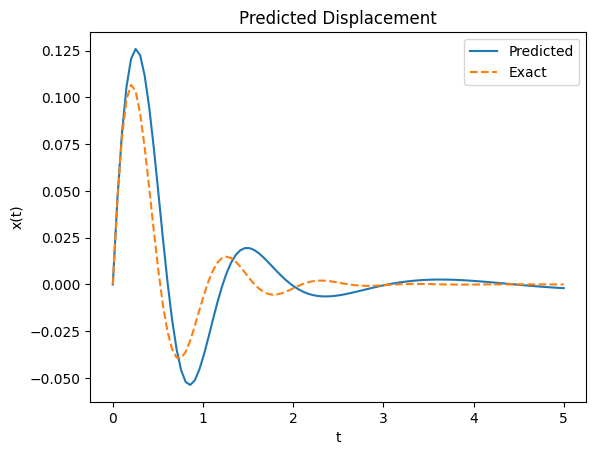

In [28]:
grid =  torch.linspace(0, duration, steps=100, device=device)
omega_d = omega * np.sqrt(1 - zeta**2)
C = 1 / omega_d
solution = torch.exp(-zeta*omega*grid) *C*torch.sin(omega_d*grid)

displacement_pred = network(grid)
plt.plot(grid.detach().cpu().numpy(), displacement_pred.detach().cpu().numpy(), label="Predicted")
plt.plot(grid.detach().cpu().numpy(), solution.detach().cpu().numpy(), label="Exact", linestyle='dashed')

plt.legend()
plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Predicted Displacement")
plt.show()


## Analysis

Well, the results aren't as nice as for the heat equation.

What I learned

- I had to increase the loss for the IC and BCs because their signal seemed to be drowned out by the number of other points.

- The gradients were less stable than before, so I added gradient clipping so they wouldn't be too large and the losses went lower.

- I needed more epics and more nuerons per layer

# Damped harmonic oscillator - a fourier approach

I was pretty disappointed with the results of the last experiment. The solution was qualitively good but didn't match the exact solution well. I did read somewhere that feature engineering is useful for PINNs and a common approach is to use fourier features. So I'll try that and see if that improves the results. I'll need to adjust my network.

In [21]:
class FourierFeatures(nn.Module):
    def __init__(self, input_dim: int, mapping_size: int, scale: float=10.0):
        super().__init__()
        B = torch.randn((input_dim, mapping_size)) * scale
        self.register_buffer("B", B)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = 2 * np.pi * x @ self.B.to(x.device)
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

def create_1d_network_with_fourier_features(num_layers: int=4, num_channels: int=32, activation=nn.SiLU, device="cuda") -> torch.nn.Module:
    """Create a 1d network"""
    layers = []

    # Add channel dimenion
    layers.append(Unsqueeze(dim=1))

    # Now I use a fourier feature layer instead of a linear layer. I also need to make sure num_channels is even so it can be split evenly between sin and cos
    layers.append(FourierFeatures(input_dim=1, mapping_size=num_channels // 2, scale=10.0))
    layers.append(activation())

    for _ in range(num_layers - 1):
        layers.append(nn.Linear(num_channels, num_channels))
        layers.append(activation())

    # Final layer to reduce to single output channel
    layers.append(nn.Linear(num_channels, 1))

    # Remove channel dimension
    layers.append(Squeeze(dim=1))
    
    network = nn.Sequential(*layers)
    return network.to(device)


# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"
network = create_1d_network(device=device)

points = torch.linspace(0, 1, steps=10, device=device).unsqueeze(-1)  # Shape (100, 1
network(points)  # Forward pass to check everything works

tensor([[-0.0048],
        [-0.0047],
        [-0.0047],
        [-0.0047],
        [-0.0047],
        [-0.0047],
        [-0.0047],
        [-0.0047],
        [-0.0048],
        [-0.0049]], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [22]:
# Training loop for a simple 1D PINN solving an initial value problem
network = create_1d_network_with_fourier_features(num_channels=128, device=device)
num_points_per_batch = 1000
num_epochs = 5000
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
mse_loss = nn.MSELoss()

# Initial displacement at x=1
x_bc = torch.tensor([0.0], device=device)
y_bc = torch.tensor([0.0], device=device)  # Initial displacement at t=0
y_ic = torch.tensor([1.0], device=device)  # Initial velocity at t=0

# Physical parameters
zeta = 0.3  # Damping ratio
omega = 2 * np.pi  # Natural frequency
duration = 5.0  # Duration of the simulation

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Input values
    interior_times = duration * torch.rand(num_points_per_batch - 2, device=device, requires_grad=True)
    sampled_times = torch.cat([x_bc, interior_times], dim=0)

    # Forward pass
    displacement_pred = network(sampled_times)

    # Compute the residual of the differential equation
    dx_dt = torch.autograd.grad(displacement_pred, sampled_times, grad_outputs=torch.ones_like(displacement_pred), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, sampled_times, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
    residual = d2x_dt2 + 2*zeta*omega*dx_dt + omega**2*displacement_pred
    residual_loss = mse_loss(residual, torch.zeros_like(residual))  # PDE residual loss, e.g., for d2x_dt2 = 0

    # Compute the boundary conditions
    bc_loss = mse_loss(displacement_pred[:1] , y_bc)  # Boundary condition loss
    ic_loss = mse_loss(dx_dt[:1] , y_ic)  # Initial condition loss

    # Total loss
    loss = residual_loss + 100 * num_points_per_batch*(bc_loss + ic_loss)

    # Backward pass and optimization step
    loss.backward()
    
    nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 263050.25
Epoch 100, Loss: 228.3134765625
Epoch 200, Loss: 559.1807250976562
Epoch 300, Loss: 34.82429504394531
Epoch 400, Loss: 53.890380859375
Epoch 500, Loss: 327.6759338378906
Epoch 600, Loss: 19.489200592041016
Epoch 700, Loss: 42.20206069946289
Epoch 800, Loss: 230.12713623046875
Epoch 900, Loss: 19.338014602661133
Epoch 1000, Loss: 29.55450439453125
Epoch 1100, Loss: 176.55616760253906
Epoch 1200, Loss: 14.107514381408691
Epoch 1300, Loss: 20.255718231201172
Epoch 1400, Loss: 131.27175903320312
Epoch 1500, Loss: 10.739059448242188
Epoch 1600, Loss: 13.78007984161377
Epoch 1700, Loss: 94.66217041015625
Epoch 1800, Loss: 9.05640983581543
Epoch 1900, Loss: 13.025369644165039
Epoch 2000, Loss: 74.38609313964844
Epoch 2100, Loss: 5.382314205169678
Epoch 2200, Loss: 13.428451538085938
Epoch 2300, Loss: 49.528900146484375
Epoch 2400, Loss: 5.397984981536865
Epoch 2500, Loss: 8.004490852355957
Epoch 2600, Loss: 28.909029006958008
Epoch 2700, Loss: 4.234798431396484
Epoch 

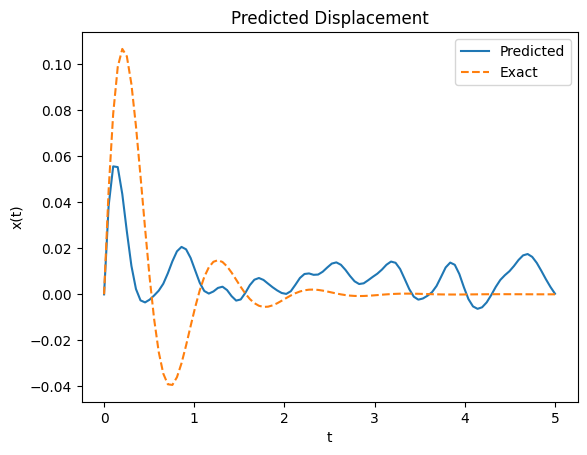

In [26]:
grid =  torch.linspace(0, duration, steps=100, device=device)
omega_d = omega * np.sqrt(1 - zeta**2)
C = 1 / omega_d
solution = torch.exp(-zeta*omega*grid) *C*torch.sin(omega_d*grid)

displacement_pred = network(grid)
plt.plot(grid.detach().cpu().numpy(), displacement_pred.detach().cpu().numpy(), label="Predicted")
plt.plot(grid.detach().cpu().numpy(), solution.detach().cpu().numpy(), label="Exact", linestyle='dashed')

plt.legend()
plt.xlabel("t")
plt.ylabel("x(t)")
plt.title("Predicted Displacement")
plt.show()


This looks even worse. It does have oscillations but the oscillations don't die out and the solutions don't align very well after a short time. I'm guessing the fourier features need more fine tuning. I'm getting tired of messing around with oscillations for now, I want to try something a bit more exciting, like fluid dynamics.

# Fluid dynamics

I never took fluid dynamics in college, it isn't a class normally taught in physics programs. Virtually all undergraduate physics courses use linear PDEs and many students don't see nonlinear ones until they get to a general relativity course. I imagine fluid dynamics being the most intuitive source of nonlinear PDEs so it would be a great course to learn nonlinear methods early on. It's been something I've wanted to learn which is why I'm interested in experimenting with it.

A lot of the following text and equations was primarly generated with AI since it is a new subject to me. I did try to reduce the technical details and add physical descriptions but is still a bit textbooky so feel free to skim this section until the summary of the governing equations or the code if you aren't interested in the details. The purpose of this isn't to learn fluid dynamics, but to see if a neural network can.

The typical equations to use are the incompressible Navier-Stokes equation, which are:

The momentum equation,

$$
\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla)\mathbf{u} = -\frac{1}{\rho} \nabla p + \nu \nabla^2 \mathbf{u}
$$,

and the continuity equation,

$$
\nabla \cdot \mathbf{u} = 0
$$,

where $\mathbf{u}$ is the velocity field, $p$ is pressure, $\rho$ is density (constant for incompressible fluids), and $\nu$ is kinematic viscosity.

Unfortunately, the pressure isn't an independent equation and must be found by solving the poisson equation evolution equation (according to chatGPT). So I'll use a different form:



## Streamfunction



The streamfunction  $\psi(x, y, t)$ can be thought of the anticurl of the velocity $\mathbf{u}(x,y)=(u,v)$ embedded in two dimensions, so that $u=\partial \psi/\partial y$ and $u=-\partial \psi/\partial x$. It has the property that

$
u = \frac{\partial \psi}{\partial y}, \quad v = -\frac{\partial \psi}{\partial x}
$

This automatically satisfies the incompressibility condition $\nabla \cdot \mathbf{u} = 0$.



The vorticity $\omega$ is the local rotation of a fluid at a point:

$
\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
$

Substituting the streamfunction expressions into the equations from above, we get the poisson equation:

$
\omega = -\nabla^2 \psi
$

The evolution of vorticity in 2D incompressible flow is governed by the vorticity transport equation:

$
\frac{\partial \omega}{\partial t} + \mathbf{u} \cdot \nabla \omega = \nu \nabla^2 \omega
$

where $\nu$ is the kinematic viscosity (I'll set it to zero to make it an inviscid fluid). We want it to be time indepndent so $\frac{\partial \omega}{\partial t}=0$.

The relevant boundary conditions that I'll use are:

- **Inflow/Outflow:** At the inflow and outflow boundary, set the velocity profile to match the desired flow.

- **No-slip walls:** On no-slip walls, both velocity components are zero, so $\psi$ is constant along the wall and its gradient matches the wall velocity.

## Neural network design



To recap, we will have two inputs for the network, (the x and y coordinates), and the output will have two outputs (the two components of the streamfunction $\psi$). We define the following:

$
\omega = -\nabla^2 \psi
$

and 

$\mathbf{u}(x,y)=(\partial \psi/\partial y, -\partial \psi/\partial x)\psi$

We have the PDE we are solving

$
 \mathbf{u} \cdot \nabla \omega = 0
$

The BCs will be to set $\mathbf{u}(x,y)$ to zero for walls and to specified values for the intake and outtake.

## First fluid experiment: A box



I'll define a box with corners at $(0,0)$, $(0,1)$, $(1,0)$, and $(1,1)$. The fluid will flow through the botom and out the top with no velocity on the left or right wall.

Mathematically, this will be $\mathbf{u}(x,0)=\mathbf{u}(x,1)=(0,1)$ and $\mathbf{u}(0,y)=\mathbf{u}(1,y)=(0,0)$

In [ ]:
class FluidFlowNetwork(nn.Module):
    def __init__(self, num_layers: int=4, num_channels: int=32, activation=nn.SiLU):
        super().__init__()
        layers = []

        # Add channel dimenion
        layers.append(nn.Linear(2, num_channels))
        layers.append(activation())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(num_channels, num_channels))
            layers.append(activation())

        # Final layer to reduce to one output channel for streamfunction
        layers.append(nn.Linear(num_channels, 1))

        self.network = nn.Sequential(*layers)

        self.network[-1].weight.data *= 10.0  # or some factor

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        steamfunction = self.network(x)
        steamfunction_grad = torch.autograd.grad(steamfunction, x, grad_outputs=torch.ones_like(steamfunction), create_graph=True)[0]
        velocity = torch.stack([steamfunction_grad[:, 1], -steamfunction_grad[:, 0]], dim=1)
        
        return steamfunction, velocity


# Example usage done in function to avoid unnecessary cuda memory usage
def example_usage():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    network = FluidFlowNetwork().to(device)

    points = torch.rand((10, 2), device=device, requires_grad=True)
    print(network(points))  # Forward pass to check everything works

example_usage()

(tensor([[ 0.0081],
        [-0.0273],
        [-0.0600],
        [-0.0105],
        [-0.0265],
        [-0.0381],
        [-0.0146],
        [ 0.0024],
        [-0.0549],
        [ 0.0029]], device='cuda:0', grad_fn=<AddmmBackward0>), tensor([[-0.0254, -0.0578],
        [-0.0450, -0.0660],
        [-0.0309, -0.0778],
        [-0.0303, -0.0630],
        [-0.0281, -0.0693],
        [-0.0264, -0.0736],
        [-0.0318, -0.0640],
        [-0.0265, -0.0596],
        [-0.0335, -0.0759],
        [-0.0340, -0.0572]], device='cuda:0', grad_fn=<StackBackward0>))


In [26]:
# Training loop for fluid flow network
network = FluidFlowNetwork(num_channels=128, activation=nn.SiLU).to(device)
num_points_per_batch = 1024
num_bc_grid_points = 128
num_epochs = 1000
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
mse_loss = nn.MSELoss()

# Physical parameters
linspace = np.linspace(0, 1, num_bc_grid_points)

# Boundary conditions coordinates
bottom_bc = torch.tensor([[x, 0.0] for x in linspace], device=device, dtype=torch.float)  # Bottom boundary
top_bc = torch.tensor([[x, 1.0] for x in linspace], device=device, dtype=torch.float)     # Top boundary
left_bc = torch.tensor([[0.0, y] for y in linspace], device=device, dtype=torch.float)   # Left boundary
right_bc = torch.tensor([[1.0, y] for y in linspace], device=device, dtype=torch.float)  # Right boundary

# Boundary condition velocities
bottom_velocity = torch.tensor([[0.0, 1.0] for _ in linspace], device=device, dtype=torch.float)  # Inflow velocity at bottom
top_velocity = torch.tensor([[0.0, 1.0] for _ in linspace], device=device, dtype=torch.float)     # Outflow velocity at top
left_velocity = torch.tensor([[0.0, 0.0] for _ in linspace], device=device, dtype=torch.float)   # No-slip on left wall
right_velocity = torch.tensor([[0.0, 0.0] for _ in linspace], device=device, dtype=torch.float)  # No-slip on right wall

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Input values
    interior_points = torch.rand((num_points_per_batch - 4 * num_bc_grid_points, 2), device=device, dtype=torch.float)
    sampled_points = torch.cat([bottom_bc, top_bc, left_bc, right_bc, interior_points], dim=0)
    sampled_points.requires_grad = True

    # Forward pass
    steamfunction_pred, velocity_pred = network(sampled_points)

    # Compute the residual of the boundary conditions
    bottom_bc_loss = mse_loss(velocity_pred[:num_bc_grid_points], bottom_velocity)
    top_bc_loss = mse_loss(velocity_pred[num_bc_grid_points:2*num_bc_grid_points], top_velocity)
    left_bc_loss = mse_loss(velocity_pred[2*num_bc_grid_points:3*num_bc_grid_points], left_velocity)
    right_bc_loss = mse_loss(velocity_pred[3*num_bc_grid_points:4*num_bc_grid_points], right_velocity)
    bc_loss = bottom_bc_loss + top_bc_loss + left_bc_loss + right_bc_loss

    # Compute the residual of the differential equation
    u_pred, v_pred = velocity_pred[:, 0], velocity_pred[:, 1]
    vorticity_pred = torch.autograd.grad(v_pred, sampled_points, grad_outputs=torch.ones_like(v_pred), create_graph=True)[0][:, 0] - torch.autograd.grad(u_pred, sampled_points, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0][:, 1]
    vorticity_grad = torch.autograd.grad(vorticity_pred, sampled_points, grad_outputs=torch.ones_like(vorticity_pred), create_graph=True)[0]

    internal_residual = torch.sum(vorticity_grad[4 * num_bc_grid_points:] * velocity_pred[4 * num_bc_grid_points:], dim=1)
    internal_loss = mse_loss(internal_residual, torch.zeros_like(internal_residual))

    # Backward pass and optimization step
    loss = internal_loss + 100 * bc_loss
    loss.backward()
    
    nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, internal loss: {internal_loss.item()}, bc loss: {bc_loss.item()}")

Epoch 0, internal loss: 3.200673148739952e-08, bc loss: 0.9553528428077698
Epoch 100, internal loss: 0.5603640675544739, bc loss: 0.1691836416721344
Epoch 200, internal loss: 0.020639220252633095, bc loss: 0.1504455953836441
Epoch 300, internal loss: 0.025868630036711693, bc loss: 0.1481025218963623
Epoch 400, internal loss: 0.029377406463027, bc loss: 0.14805135130882263
Epoch 500, internal loss: 0.04248998314142227, bc loss: 0.14693351089954376
Epoch 600, internal loss: 0.033971451222896576, bc loss: 0.14585067331790924
Epoch 700, internal loss: 0.047322262078523636, bc loss: 0.1456606686115265
Epoch 800, internal loss: 0.03469591587781906, bc loss: 0.14513474702835083
Epoch 900, internal loss: 0.030324866995215416, bc loss: 0.14466997981071472


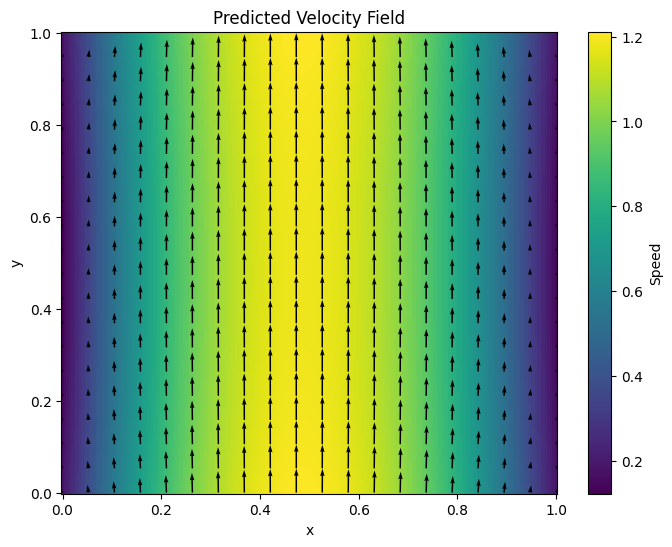

In [28]:
# Plot of predicted velocity field

def to_numpy(tensor: torch.Tensor) -> np.ndarray:
    """
    Convert a PyTorch tensor to a NumPy array safely for plotting.
    Works for tensors on GPU and/or requiring gradients.
    """
    return tensor.detach().cpu().numpy()

plt.figure(figsize=(8, 6))

# Color map of speed
color_grid_size = 200
x = torch.linspace(0, 1, color_grid_size)
y = torch.linspace(0, 1, color_grid_size)
X, Y = torch.meshgrid(x, y, indexing='ij')
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)
grid_points.requires_grad = True
_steamfunction_pred, velocity_pred = network(grid_points)
speed = torch.sqrt(torch.sum(velocity_pred**2, dim=1)).reshape(X.shape)
plt.pcolormesh(to_numpy(X), to_numpy(Y), to_numpy(speed), shading='auto', cmap='viridis')
plt.colorbar(label='Speed')

# Quiver plot of velocity vectors
quiver_grid_size = 20
x = torch.linspace(0, 1, quiver_grid_size)
y = torch.linspace(0, 1, quiver_grid_size)
X, Y = torch.meshgrid(x, y, indexing='ij')
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)
grid_points.requires_grad = True
_steamfunction_pred, velocity_pred = network(grid_points)
arrow_scale = 2
np_velocity_pred = to_numpy(arrow_scale * velocity_pred)
u_pred, v_pred = np_velocity_pred[:, 0], np_velocity_pred[:, 1]
plt.quiver(to_numpy(X), to_numpy(Y), u_pred, v_pred, color='black', scale=50)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Velocity Field")
plt.show()

Looks pretty realistiic, although boring. Also the BCs on the corners on the top and bottom don't look satisfied, but only at the very end.

## Flowing around a ball

Now let's try it again, but this time I'll stick a ball in the middle to try to get the fluid to flow around it. I'll do that by setting setting the velocities to zero within the ball by defining an mse loss to zero for the internal points

In [20]:
# Training loop for fluid flow network
network = FluidFlowNetwork(num_channels=512, num_layers=6).to(device)
num_points_per_batch = 1024
num_bc_grid_points = 128
num_epochs = 10000
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
mse_loss = nn.MSELoss()

# Physical parameters
linspace = np.linspace(0, 1, num_bc_grid_points)
ball_center = np.array([0.5, 0.5])
ball_radius = 0.2

# Boundary conditions coordinates
bottom_bc = torch.tensor([[x, 0.0] for x in linspace], device=device, dtype=torch.float)  # Bottom boundary
top_bc = torch.tensor([[x, 1.0] for x in linspace], device=device, dtype=torch.float)     # Top boundary
left_bc = torch.tensor([[0.0, y] for y in linspace], device=device, dtype=torch.float)   # Left boundary
right_bc = torch.tensor([[1.0, y] for y in linspace], device=device, dtype=torch.float)  # Right boundary
ball_bc = torch.tensor([[ball_center[0] + ball_radius * np.cos(2 * np.pi * theta), ball_center[1] + ball_radius * np.sin(2 * np.pi * theta)] for theta in linspace], device=device, dtype=torch.float)

# Boundary condition velocities
bottom_velocity = torch.tensor([[0.0, 1.0] for _ in linspace], device=device, dtype=torch.float)  # Inflow velocity at bottom
top_velocity = torch.tensor([[0.0, 1.0] for _ in linspace], device=device, dtype=torch.float)     # Outflow velocity at top
left_velocity = torch.tensor([[0.0, 0.0] for _ in linspace], device=device, dtype=torch.float)   # No-slip on left wall
right_velocity = torch.tensor([[0.0, 0.0] for _ in linspace], device=device, dtype=torch.float)  # No-slip on right wall
ball_velocity = torch.tensor([[0.0, 0.0] for _ in linspace], device=device, dtype=torch.float)   # No-slip on ball surface

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Input values
    interior_points = torch.rand((2*num_points_per_batch, 2), device=device, dtype=torch.float, requires_grad=True)
    distance = torch.sqrt((interior_points[:, 0] - ball_center[0])**2 + (interior_points[:, 1] - ball_center[1])**2)
    mask = (distance >= ball_radius)
    valid_interior_points = interior_points[mask][: num_points_per_batch - 5 * num_bc_grid_points]

    sampled_points = torch.cat([bottom_bc, top_bc, left_bc, right_bc, ball_bc, valid_interior_points], dim=0)

    # Forward pass
    steamfunction_pred, velocity_pred = network(sampled_points)

    # Compute the residual of the boundary conditions
    bottom_bc_loss = mse_loss(velocity_pred[:num_bc_grid_points], bottom_velocity)
    top_bc_loss = mse_loss(velocity_pred[num_bc_grid_points:2*num_bc_grid_points], top_velocity)
    left_bc_loss = mse_loss(velocity_pred[2*num_bc_grid_points:3*num_bc_grid_points], left_velocity)
    right_bc_loss = mse_loss(velocity_pred[3*num_bc_grid_points:4*num_bc_grid_points], right_velocity)
    ball_bc_loss = mse_loss(velocity_pred[4*num_bc_grid_points:5*num_bc_grid_points], ball_velocity)
    bc_loss = bottom_bc_loss + top_bc_loss + left_bc_loss + right_bc_loss + ball_bc_loss

    # Compute the residual of the differential equation
    u_pred, v_pred = velocity_pred[:, 0], velocity_pred[:, 1]
    vorticity_pred = torch.autograd.grad(v_pred, sampled_points, grad_outputs=torch.ones_like(v_pred), create_graph=True)[0][:, 0] - torch.autograd.grad(u_pred, sampled_points, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0][:, 1]
    vorticity_grad = torch.autograd.grad(vorticity_pred, sampled_points, grad_outputs=torch.ones_like(vorticity_pred), create_graph=True)[0]

    internal_residual = torch.sum(vorticity_grad[5 * num_bc_grid_points:] * velocity_pred[5 * num_bc_grid_points:], dim=1)
    internal_loss = mse_loss(internal_residual, torch.zeros_like(internal_residual))

    # Backward pass and optimization step
    loss = 100 * bc_loss + internal_loss
    loss.backward()
    
    # nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, internal loss: {internal_loss.item()}, bc loss: {bc_loss.item()}")

Epoch 0, internal loss: 8.105148496806436e-12, bc loss: 0.9910624027252197
Epoch 100, internal loss: 8.831937884679064e-05, bc loss: 0.5898252725601196
Epoch 200, internal loss: 0.02930564433336258, bc loss: 0.44659507274627686
Epoch 300, internal loss: 0.03313259035348892, bc loss: 0.4459173083305359
Epoch 400, internal loss: 0.028598463162779808, bc loss: 0.44556447863578796
Epoch 500, internal loss: 0.028355788439512253, bc loss: 0.44511473178863525
Epoch 600, internal loss: 0.02464587613940239, bc loss: 0.44450643658638
Epoch 700, internal loss: 0.0129320677369833, bc loss: 0.4429240822792053
Epoch 800, internal loss: 0.02349296770989895, bc loss: 0.4394533038139343
Epoch 900, internal loss: 0.11970590054988861, bc loss: 0.4336380660533905
Epoch 1000, internal loss: 0.22496138513088226, bc loss: 0.42888718843460083
Epoch 1100, internal loss: 0.3312608599662781, bc loss: 0.42578545212745667
Epoch 1200, internal loss: 0.3920688331127167, bc loss: 0.42628830671310425
Epoch 1300, inter

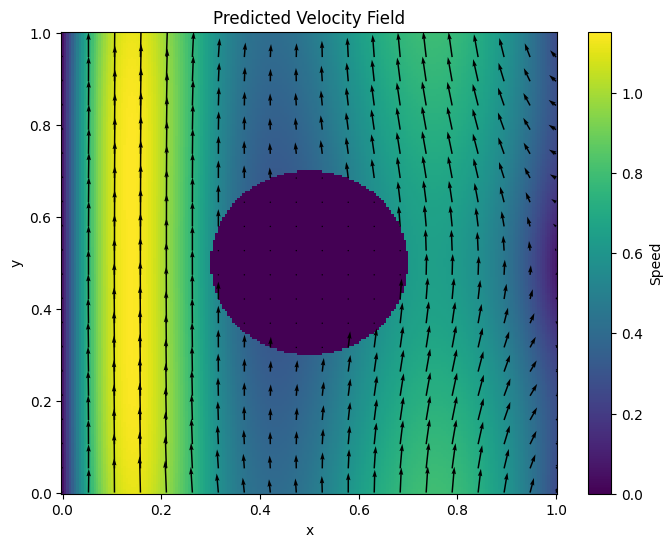

In [24]:
# Plot of predicted velocity field

def to_numpy(tensor: torch.Tensor) -> np.ndarray:
    """
    Convert a PyTorch tensor to a NumPy array safely for plotting.
    Works for tensors on GPU and/or requiring gradients.
    """
    return tensor.detach().cpu().numpy()

plt.figure(figsize=(8, 6))

# Colormap of speed
color_grid_size = 200
x = torch.linspace(0, 1, color_grid_size)
y = torch.linspace(0, 1, color_grid_size)
X, Y = torch.meshgrid(x, y, indexing='ij')
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)
grid_points.requires_grad = True
_steamfunction_pred, velocity_pred = network(grid_points)
speed = torch.sqrt(torch.sum(velocity_pred**2, dim=1)).reshape(X.shape)

# Mask out the ball area
distance = torch.sqrt((X - ball_center[0])**2 + (Y - ball_center[1])**2)
mask = (distance >= ball_radius).to(device)
speed = speed * mask

plt.pcolormesh(to_numpy(X), to_numpy(Y), to_numpy(speed), shading='auto', cmap='viridis')
plt.colorbar(label='Speed')

# Quiver plot of velocity vectors
quiver_grid_size = 20
x = torch.linspace(0, 1, quiver_grid_size)
y = torch.linspace(0, 1, quiver_grid_size)
X, Y = torch.meshgrid(x, y, indexing='ij')
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)
grid_points.requires_grad = True
_steamfunction_pred, velocity_pred = network(grid_points)

# Mask out the ball area
distance = torch.sqrt((X - ball_center[0])**2 + (Y - ball_center[1])**2)
mask = (distance >= ball_radius).to(device)
velocity_pred = velocity_pred * mask.flatten().unsqueeze(-1)
u_pred, v_pred = velocity_pred[:, 0], velocity_pred[:, 1]
plt.quiver(to_numpy(X), to_numpy(Y), to_numpy(u_pred), to_numpy(v_pred), color='black', scale=15)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Predicted Velocity Field")
plt.show()

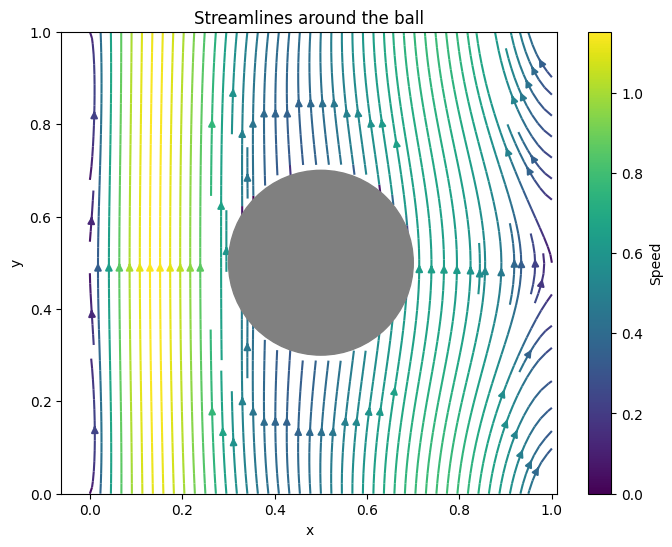

In [22]:
color_grid_size = 128

# Make a proper grid for streamplot
x = torch.linspace(0, 1, color_grid_size, requires_grad=True)
y = torch.linspace(0, 1, color_grid_size, requires_grad=True)
X, Y = torch.meshgrid(x, y, indexing='xy')  # xy indexing

grid_points = torch.stack([X.flatten(), Y.flatten()], dim=-1).to(device)
_, velocity_pred = network(grid_points)

# Convert to 2D arrays
U = velocity_pred[:, 0].reshape(Y.shape)  # rows = len(y), cols = len(x)
V = velocity_pred[:, 1].reshape(Y.shape)
speed = torch.sqrt(U**2 + V**2)

# Mask inside the ball
distance = torch.sqrt((X - ball_center[0])**2 + (Y - ball_center[1])**2)
mask = (distance >= ball_radius).to(device)
U = U * mask
V = V * mask
speed = speed * mask

plt.figure(figsize=(8, 6))
plt.streamplot(to_numpy(x), to_numpy(y), to_numpy(U), to_numpy(V),
               color=to_numpy(speed), cmap='viridis', density=1.5)
plt.colorbar(label='Speed')

# Draw the ball
circle = plt.Circle(ball_center, ball_radius, color='gray', zorder=10)
plt.gca().add_patch(circle)

plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.title("Streamlines around the ball")
plt.show()


The more I train the worse it looks. I think this problem is much more difficult than I suspected. I think the difficulty here is the level of derivative being taken. The velocity is the first derivative, the vorticity is the second derivative, and we use the gradient (third derivative) of the vorticity for the loss. So when we finally take the gradient of the loss we are on the fourth derivative.

The internal loss is nearly zero at the beginning. This is because the initial parameters